In [2]:
import scipy.integrate
import pints
import pints.plot
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pints.toy

np.random.seed(123)

In [59]:
def load_wolf_moose_data(file_location):
    """Load the Wolves & Moose of Isle Royale data from csv file.
    
    Parameters
    ----------
    file_location : str
        path to the csv file containing the wolf-moose population numbers. The file should contain 
        the year in the first column, no. of moose in the second column, and the no. of wolves in the third column.

    Returns
    -------
    pandas.DataFrame
        Wolves & Moose of Isle Royale
    """
    names = ["year", "wolf", "moose"]
    df = pd.read_csv(file_location, header=None, names=names)
    return df

df = load_wolf_moose_data("wolf_moose_data.csv")
df['modified time'] = df['year'].values - 1959
mod_times = df['modified time'].values 
observed_data = df[['wolf', 'moose']].values
init_wolves, init_moose = df['wolf'].iloc[0], df['moose'].iloc[0]

class LotkaVolterraModel(pints.ForwardModel):

    def __init__(self, method="RK45", rtol=1e-6, atol=1e-6):
        """
        Parameters
        ----------
        method : str or scipy solver
            Solver method for solving ODE
        rtol : float
            Relative tolerance of ODE solution (applies to adaptive solvers)
        atol : float
            Absolute tolerance of ODE solution (applies to adaptive solvers)
        """
        super().__init__()
        self.method = method
        self.rtol = rtol
        self.atol = atol

    def n_outputs(self):
        """ See :meth:`pints.ForwardModel.n_outputs()`. """
        return 2

    def n_parameters(self):
        return 4

    def simulate(self, parameters, times):
        a, b, c, d = parameters

        def dy(t, state):
            x, y = state
            dx= a * x - b * x * y 
            dy = -c * y + d * x * y
            
            return (dx, dy)

        initial_condition = np.asarray([np.log(init_moose), np.log(init_wolves)])

        res = scipy.integrate.solve_ivp(
            dy,
            (mod_times[0], mod_times[-1]),
            initial_condition,
            t_eval=mod_times)
        
        return res.y.T

In [46]:
print(df)

    year  wolf  moose  modified time
0   1959    20    538              0
1   1960    22    564              1
2   1961    22    572              2
3   1962    23    579              3
4   1963    20    596              4
..   ...   ...    ...            ...
56  2015     3   1250             56
57  2016     2   1300             57
58  2017     2   1600             58
59  2018     2   1475             59
60  2019    15   2060             60

[61 rows x 4 columns]


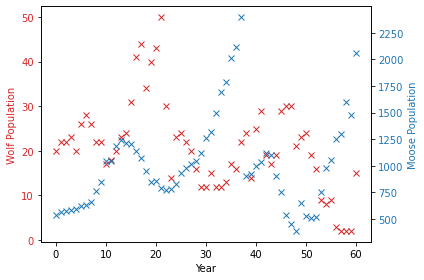

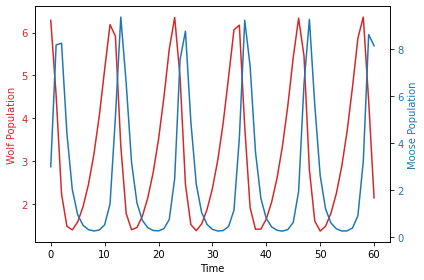

In [60]:
#import pints.toy
#m = pints.toy.LotkaVolterraModel()

# Plot wolf and moose populations
fig, ax1 = plt.subplots()

ax1.set_xlabel('Year')
ax1.set_ylabel('Wolf Population', color='tab:red')
ax1.plot(mod_times, df['wolf'], 'x', color='tab:red', label='Wolves')
ax1.tick_params(axis='y', labelcolor='tab:red')

ax2 = ax1.twinx()
ax2.set_ylabel('Moose Population', color='tab:blue')
ax2.plot(mod_times, df['moose'], 'x', color='tab:blue', label='Moose')
ax2.tick_params(axis='y', labelcolor='tab:blue')

fig.tight_layout()
plt.show()

# Make a model object and run a simulation at arbitrary parameter values
m = LotkaVolterraModel()
# times1 = np.linspace(0, 20, 100)
params = [0.28, 0.11, 1.37, 0.42]
#init_wolves, init_moose = 5, 30
#df['wolf'].iloc[0], df['moose'].iloc[0]
y = m.simulate(params, mod_times)

fig, ax1 = plt.subplots()

ax1.set_xlabel('Time')
ax1.set_ylabel('Wolf Population', color='tab:red')
ax1.plot(mod_times, y[:, 0], color='tab:red', label='Wolves')
ax1.tick_params(axis='y', labelcolor='tab:red')

ax2 = ax1.twinx()
ax2.set_ylabel('Moose Population', color='tab:blue')
ax2.plot(mod_times, y[:, 1], color='tab:blue', label='Moose')
ax2.tick_params(axis='y', labelcolor='tab:blue')

fig.tight_layout()
plt.show()

In [43]:
print(observed_data)
print(mod_times)

[[  20  538]
 [  22  564]
 [  22  572]
 [  23  579]
 [  20  596]
 [  26  620]
 [  28  634]
 [  26  661]
 [  22  766]
 [  22  848]
 [  17 1041]
 [  18 1045]
 [  20 1183]
 [  23 1243]
 [  24 1215]
 [  31 1203]
 [  41 1139]
 [  44 1070]
 [  34  949]
 [  40  845]
 [  43  857]
 [  50  788]
 [  30  767]
 [  14  780]
 [  23  830]
 [  24  927]
 [  22  976]
 [  20 1014]
 [  16 1046]
 [  12 1116]
 [  12 1260]
 [  15 1315]
 [  12 1496]
 [  12 1697]
 [  13 1784]
 [  17 2017]
 [  16 2117]
 [  22 2398]
 [  24  900]
 [  14  925]
 [  25  997]
 [  29 1031]
 [  19 1120]
 [  17 1100]
 [  19  900]
 [  29  750]
 [  30  540]
 [  30  450]
 [  21  385]
 [  23  650]
 [  24  530]
 [  19  510]
 [  16  515]
 [   9  750]
 [   8  975]
 [   9 1050]
 [   3 1250]
 [   2 1300]
 [   2 1600]
 [   2 1475]
 [  15 2060]]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60]


In [116]:
# Step 5: Set up the problem
problem = pints.MultiOutputProblem(m , times, np.log(observed_data))
error = pints.SumOfSquaresError(problem)

# Step 6: Create the log-posterior
log_prior_theta = pints.UniformLogPrior(lower_or_boundaries=0, upper=10)
log_prior_sigma = pints.GaussianLogPrior(mean=0, sd=3)
log_prior = pints.ComposedLogPrior(log_prior_theta, log_prior_theta, log_prior_theta, log_prior_theta,
                                   log_prior_sigma, log_prior_sigma)
log_likelihood = pints.GaussianLogLikelihood(problem)
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

transformation = pints.RectangularBoundariesTransformation(
    [0.01, 0.01, 0.01, 0.01],
    [10.0, 10.0, 10, 10.0])

opt = pints.OptimisationController(
    error,
    [0.5, 0.02, 0.1, 0.5],
    method=pints.CMAES,
    transformation=transformation
)

opt.set_log_interval(200)
opt.set_max_evaluations(200)

found_parameters, found_value = opt.run()

print("Fit parameters:", found_parameters)

Minimising error measure
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in sequential mode.
Population size: 8
Iter. Eval. Best      Current   Time m:s
0     8      6788.404  6788.404   0:00.0
1     16     1165.579  1165.579   0:00.1
2     24     1165.579  1708.819   0:00.1
3     32     1165.579  1641.873   0:00.1

----------------------------------------
Unexpected termination.
Current score: 1328.4189430634042
Current position:
 7.01231603732065722e-01
 4.40724664396440202e-01
 2.79529225651579255e-02
 2.36658025343694997e-02
----------------------------------------


KeyboardInterrupt: 

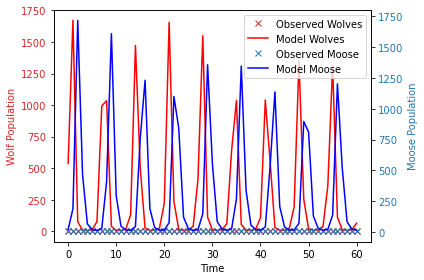

In [115]:
# Evaluate the model with the found parameters and plot the results
fig, ax1 = plt.subplots()

# Plot observed wolf population
ax1.set_xlabel('Time')
ax1.set_ylabel('Wolf Population', color='tab:red')
ax1.plot(mod_times, np.log(observed_data)[:, 0], 'x', label='Observed Wolves', color='tab:red')
ax1.plot(mod_times, np.exp(problem.evaluate(found_parameters)[:, 0]), label='Model Wolves', color='red')
ax1.tick_params(axis='y', labelcolor='tab:red')

# Plot observed moose population
ax2 = ax1.twinx()
ax2.set_ylabel('Moose Population', color='tab:blue')
ax2.plot(mod_times, np.log(observed_data)[:, 1], 'x', label='Observed Moose', color='tab:blue')
ax2.plot(mod_times, np.exp(problem.evaluate(found_parameters)[:, 1]), label='Model Moose', color='blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')

fig.tight_layout()
fig.legend(loc='upper right', bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
plt.show()

In [51]:
print(problem.evaluate(found_parameters)[:, 0])
print(problem.evaluate(found_parameters)[:, 1])

[6.28785856 5.49721716 1.74926237 2.05441305 5.41144271 6.56963834
 1.99676891 1.83322231 4.50933297 7.42589838 2.52609568 1.70156091
 3.58283602 7.6220005  3.16095935 1.67241296 3.0116037  7.22117176
 4.00718412 1.71467093 2.58621375 6.50655082 4.9986006  1.8337221
 2.27114906 5.66649592 5.98507163 2.03480243 2.04735793 4.87685841
 6.78161957 2.32756915 1.89933931 4.17254065 7.22988182 2.73617091
 1.8153976  3.58243298 7.27896792 3.28984549 1.78981128 3.10672618
 6.9875425  3.9788214  1.82034225 2.72910371 6.44885467 4.78215793
 1.90897044 2.4335386  5.78875185 5.60680662 2.06178611 2.20947646
 5.12426466 6.32810985 2.28491285 2.04693035 4.49703895 6.84242877
 2.58774793]
[2.99573227 5.82898994 4.90358756 3.08936902 2.77998754 5.41317839
 5.30448413 3.33927422 2.67903056 4.79276769 5.72154958 3.71671805
 2.70020067 4.01910207 5.94426128 4.05284799 2.78335843 3.51638164
 5.98667683 4.40181947 2.91517368 3.16466703 5.82943643 4.75525593
 3.08942749 2.94591416 5.48097494 5.09380736 3.296

In [ ]:
import pints.residuals_diagnostics

pints.residuals_diagnostics.plot_residuals_autocorrelation(np.asarray([found_parameters]), problem)
plt.show()

pints.residuals_diagnostics.plot_residuals_vs_output(np.asarray([found_parameters]), problem)
plt.show()

In [ ]:
plt.plot(times, y, 'x', label='Data')
plt.plot(times, problem.evaluate(found_parameters[:-2]), label='Model fit', color='k')
plt.legend()
plt.show()
